In [124]:
#!pip uninstall visualkeras

In [125]:
#!pip install scikit-learn

In [126]:
#!pip install tensorflow-gpu

In [127]:
#!pip install pandas

In [128]:
#!pip install wandb

In [129]:
#!pip install numpy

In [130]:
#!pip install openpyxl

In [131]:
#Manejo de Datos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import boxcox


#Machine learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import Callback

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

#Librerias estandar (Extras)
import re
import os
import time
import random
from datetime import datetime

In [132]:
"""
DIRECTORIOS DEL PROYECTO
"""
path_base = 'C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/GPUTesis'   # Directorio del proyecto
path_imagenes = 'F:/GOES/'                                         # Directorio de las imagenes procesadas
#listDataset = [f'{path_base}/Archivos/Dataset/datasetMuestra.csv']          # Directorio(s) de los datos de precipitacion
listDataset = [f'{path_base}/Archivos/Dataset/CLASE_TrainDS.csv']          # Directorio(s) de los datos de precipitacion
#CLASE_TrainDS

In [133]:
!python --version
print(tf. __version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

#Limitamos el GPU, en caso se necesite
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_virtual_device_configuration(gpus[0],
                                                        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])

Python 3.9.112.8.0

Num GPUs Available:  1


In [134]:
#conda list cudnn

In [135]:
#conda list cudatoolkit

In [136]:
"""
Metodos para realizar el entrenamient - evaluacion del modelo
"""

'\nMetodos para realizar el entrenamient - evaluacion del modelo\n'

In [137]:

#Lee el archivo "filename" de datos de precipitacion y
#regresa un df que facilite la lectura del dataset para el entrenmaiento
def obtenerDatos(filename):
    start_time = time.time()
    pdata = pd.read_csv(filename)
    
    # Quitamos los valores NA
    pdata = pdata[pdata['dato'].notna()]

    # Definimos un solo tipo (str) pora asi poder convertirlo a tensor
    pdata = pdata.astype({"dato": str, "XO": str, "XA": str, "fecha": str})

    #Definimos la nueva columna para guardar el XO, XA y fecha
    pdata['imagen'] = pdata.apply(obtenerDir, axis=1)

    # Seleccionamos solo las columnas necesarias :
    # precipitacion, Estacion (Longitud), Estacion (Latitud), Fecha (año-mes-dia-hora)
    #pdataX = pdata.loc[:, ['dato','umbral','altura', 'imagen', 'fecha']]
    pdata = pdata.astype({"dato": str, "umbral": str, "altura": str, "imagen": str, "fecha": str})

    # Barajeamos los datos
    pdata = shuffle(pdata)

    print(f'{len(pdata)} datos leidos')
    print("Tiempo tomado en leer datos: %.2fs" % (time.time() - start_time))
    return pdata

In [138]:

# Devuelve una lista con lo indices que no se encontraron lso archivos y el producto
# Servira para ver si se teinen todas los frames de la fecha
def comprobarFrames(dfOrignial, path_base, products, times, delete=1):
    
    #dfOrignial = obtenerDatos(datafile)
    
    
    start_time = time.time()
    
    dfTotal = pd.unique(dfOrignial['fecha'])
    no_fecha = []
    for fecha in dfTotal:
        year, month, day, hour = fecha.split('-')
        existe = True
        for p in products:
            for t in range(len(times)):             
                filename = f'{path_base}PNG/{fecha}/{fecha}_{t}.png'
                try:                    
                    file_size = os.path.getsize(filename)
                    existe = file_size > 4100000
                except: 
                    existe = False
                    break
                
            if not existe:
                break
        if not existe:
            no_fecha.append(fecha)
            

    if delete:
        antes = len(dfOrignial)
        df2 = dfOrignial[~dfOrignial['fecha'].isin(no_fecha)]
        despues = len(df2)
        print(f'{antes - despues}/{antes} datos eliminados: No se encontraron los archivos de imagenes satelitales')
    else:
        df2 = dfOrignial

    print("Tiempo tomado en verificar datos: %.2fs" % (time.time() - start_time))
    return df2, no_fecha

In [139]:
#Del dataset guardamos los datos mas importantes en una columna para facilitar su lectura
def obtenerDir(row):
    fecha = row['fecha']

    year, month, day, hour = fecha.split('-')
    # filename = f'{path_base}comprimido/{year}_{month}_{day}/{hour}/'
    return f"{row['XO']}--{row['XA']}--{fecha}"

In [140]:
def limpiarDatos(listNames, path_imagenes, products, times ,ceros = 0.0 ,delete=1):
    df = []
    start_time = time.time()
    print(f'Se leera los archivos de datasets...')
    for name in listNames:
        try:
            df.append(pd.read_csv(name))   
        except:
            print(f'No se pudo leer el archivo {name} de dataset')
            return -1
        
    if len(df)>2:
        dsCompleto =  pd.concat(df, ignore_index=True) 
    else:
        dsCompleto =  df[0]
        
    print("Tiempo tomado: %.2fs" % (time.time() - start_time))
    print(f'+Cantidad de datos leidos {len(dsCompleto)}')
    
    # Quitamos los NA valores
    print(f'\nSe elimnara los valores nulos y dudosos')
    dsCompleto.dropna(subset=['dato'], axis='index', inplace=True)    
    dsCompleto = dsCompleto[dsCompleto['flag']!='ND']
    dsCompleto = dsCompleto[dsCompleto['flag'].isin(['C0000002','M0000002'])]
    print("Tiempo tomado: %.2fs" % (time.time() - start_time))
    print(f'+Cantidad de datos luego de elimnar nulos {len(dsCompleto)}')
              
    
    # Buscamos imagenes satelitales para lso archivos
    print(f'\nSe buscara las imagenes satelitales para los datos...')
    dfImagenes, no_fecha = comprobarFrames(dsCompleto, path_imagenes, products, times, delete)    
    print("Tiempo tomado: %.2fs" % (time.time() - start_time))
       
        
        
    #Limitamos la cantidad de ceros
    if ceros:
        print(f'\nSe limitara el numero de ceros al {ceros*100:.2f} porciento...')
        dsNoNulo = dfImagenes[dfImagenes['dato']!=0]
        dsNulo = dfImagenes[dfImagenes['dato']==0]
        dsNulo = dsNulo.sample(n=int(ceros*len(dsNoNulo)))        
        dfImagenes = pd.concat([dsNoNulo,dsNulo], ignore_index=True) 
        print(f'+Cantidad de datos luego de limtar ceros {len(dfImagenes)}')
    
    #Agregamos lso datos de las estaciones al dataset
    print(f'\nSe agregara los datos de las estaciones(cordenadas, umbral)...')
    dfImagenes['imagen'] = dfImagenes.apply(obtenerDir, axis=1)        
    print(f'-------> CANTIDAD FINAL DE DATOS :  {len(dfImagenes)} <--------------')  
    print("Tiempo total: %.2fs" % (time.time() - start_time))
    return shuffle(dfImagenes), no_fecha

In [141]:
def crearModelo2D(p,run):    
    print(f"Creadno modelo con input ({p['margen'][run]},{p['margen'][run]},{p['canales'][run]})) tipo ({p['outputs']})")
    # Imagen
    input_1 = tf.keras.layers.Input(shape=(p['margen'][run],p['margen'][run],p['canales'][run]))
    
    # Convulutional layers
    rescaling = tf.keras.layers.Rescaling(1./65536)(input_1)
    conv2d_1 = tf.keras.layers.Conv2D(128, kernel_size=3,padding='same',activation=tf.keras.activations.relu)(rescaling)
    mxPool_1 = tf.keras.layers.MaxPooling2D()(conv2d_1)
    dropout_1  = tf.keras.layers.Dropout(0.2)(mxPool_1)
    
    conv2d_2 = tf.keras.layers.Conv2D(64, kernel_size=3,padding='same',activation=tf.keras.activations.relu)(dropout_1)
    mxPool_2 = tf.keras.layers.MaxPooling2D()(conv2d_2)
    dropout_2  = tf.keras.layers.Dropout(0.1)(mxPool_2)
    
    conv2d_3 = tf.keras.layers.Conv2D(32, kernel_size=3,padding='same',activation=tf.keras.activations.relu)(dropout_1)
    mxPool_3 = tf.keras.layers.MaxPooling2D()(conv2d_3)
    dropout_3  = tf.keras.layers.Dropout(0.2)(mxPool_3)
    
    conv2d_4 = tf.keras.layers.Conv2D(64, kernel_size=3,padding='same',activation=tf.keras.activations.relu)(dropout_3)
    mxPool_4 = tf.keras.layers.MaxPooling2D()(conv2d_4)
    dropout_4  = tf.keras.layers.Dropout(0.2)(mxPool_4)
    
    conv2d_5 = tf.keras.layers.Conv2D(32, kernel_size=3,padding='same',activation=tf.keras.activations.relu)(dropout_4)
    
    
    # Flatten layer :
    flatten = tf.keras.layers.Flatten()(conv2d_5)
    
    final = flatten
    listConcat = [flatten]
    listInputs = [input_1]
    
    if len(p['inputs'])>1:
        #Agregamos los otros atrbutos        
        for attr in p['inputs'][1:]:
            # The other input
            input_x = tf.keras.layers.Input(shape=(1,))
            listConcat.append(input_x)
            listInputs.append(input_x)

            
        # Concatenate
        final = tf.keras.layers.Concatenate()(listConcat)
        
    dense_1 = tf.keras.layers.Dense(units=32, activation=tf.keras.activations.relu)(final)
    dense_2 = tf.keras.layers.Dense(units=16, activation=tf.keras.activations.relu)(dense_1)
    dense_3 = tf.keras.layers.Dense(units=32, activation=tf.keras.activations.relu)(dense_2)
    
        
    # output
    if p['outputs'] in ['dato','lambda']:
        output = tf.keras.layers.Dense(units=1)(dense_3)
        dimOutput = 1
    elif p['outputs'] == 'umbral':
        output = tf.keras.layers.Dense(units=1, activation=tf.keras.activations.sigmoid)(dense_3)
        dimOutput = 2
    else:
        print(f"No se pudo crear el modelo outputs no esta bien definido {p['outputs']}")
        return -1      
    

    full_model = tf.keras.Model(inputs=listInputs, outputs=[output])
    
    print('DONE')
    
    #print(full_model.summary())
    return full_model

In [142]:
def crearModelo3D(p,run):    
    print(f"Creando modelo con input ({p['tiempos'][run]},{p['margen'][run]},{p['margen'][run]},{p['canales'][run]})) y ({p['outputs']})...")
    # Imagen
    input_1 = tf.keras.layers.Input(shape=(p['tiempos'][run],p['margen'][run],p['margen'][run],p['canales'][run]))
    
    # first conv layer :
    conv3d_1 = tf.keras.layers.Conv3D(64, kernel_size=3,activation=tf.keras.activations.relu)(input_1)

    # Second conv layer :
    conv3d_2 = tf.keras.layers.Conv3D(32, kernel_size=3,activation=tf.keras.activations.relu)(conv3d_1)
    
    # Flatten layer :
    flatten = tf.keras.layers.Flatten()(conv3d_2)
    
    final = flatten
    listConcat = [flatten]
    listInputs = [input_1]
    
    if len(p['inputs'])>1:
        #Agregamos los otros atrbutos        
        for attr in p['inputs'][1:]:
            # The other input            
            input_x = tf.keras.layers.Input(shape=(1,))
            listConcat.append(input_x)
            listInputs.append(input_x)
            
        # Concatenate
        final = tf.keras.layers.Concatenate()(listConcat)
        
        
    # output
    if p['outputs'] in ['dato','lambda']:
        output = tf.keras.layers.Dense(units=1, activation=tf.keras.activations.softmax)(final)
        dimOutput = 1
    elif p['outputs'] == 'umbral':
        output = tf.keras.layers.Dense(units=2, activation=tf.keras.activations.sigmoid)(final)
        dimOutput = 2
    else:
        print(f"No se pudo crear el modelo outputs no esta bien definido {p['outputs']}")
        return -1          

    full_model = tf.keras.Model(inputs=listInputs, outputs=[output])
    
    
    print('DONE')
    #print(full_model.summary())
    return full_model

In [143]:
def crearModelo(params,run):     
    if params['tiempos'][run] == 1:
        #Se crea un modelo conv2D
        return crearModelo2D(params,run)         
    else:
        #Se crea un modelo conv3D
        #return crearModelo2D(params,run)       
        return crearModelo2D(params,run)       

In [144]:
#Transformamos un filename tensor en una imagen
def read_png_file(item, value, p,run, path_base, products, times):
    # imagenData[0] = XO     # imagenData[1] = XA     # imagenData[2] = Fecha
    imagenData = tf.strings.split(item['imagen'], sep='--')
    size = int(p['margen'][run] / 2)

    timeJoin = []
    for j in range(p['tiempos'][run]-1,-1,-1):
        filename = path_base + 'PNG/' + imagenData[2] + '/' + imagenData[2] + '_' + str(j) + '.png'
        
        image_string = tf.io.read_file(filename)

        img_decoded = tf.io.decode_png(image_string, dtype=tf.uint16, channels=3)
        
        
                
        timeJoin.insert(0,img_decoded[int(imagenData[1]) - size:int(imagenData[1]) + size,
                                      int(imagenData[0]) - size:int(imagenData[0]) + size,
                                      0:p['canales'][run]])
 
        
    if p['tiempos'][run]==1:
        imagenData = tf.reshape(timeJoin[0],(p['margen'][run],p['margen'][run],p['canales'][run]))
    else:
        #img = tf.stack(timeJoin, axis=0)
        img = tf.reduce_mean( timeJoin , axis=0 )
        imagenData = tf.reshape(img,(p['margen'][run],p['margen'][run],p['canales'][run]))
        
    
    
    if len(p['inputs']) == 1:
        return imagenData, int(value)
    
    item['imagen'] = imagenData
    itemL = []
    for inpL in p['inputs']:
        itemL.append(item[inpL])
    
    return tuple(itemL), int(value)

In [145]:
def getMetrics(modelType, lr, paciencia):
    
    if modelType == 'umbral':    
        optimizer = keras.optimizers.Adam(learning_rate=lr) 
        loss_fn=keras.losses.BinaryCrossentropy()       
        train_acc_metric = keras.metrics.BinaryCrossentropy()
        val_acc_metric = keras.metrics.BinaryCrossentropy()
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_acc", patience=paciencia, mode="max")  
 
        
        metrics = ['acc', tf.keras.metrics.TruePositives(),
                         tf.keras.metrics.TrueNegatives(),
                         tf.keras.metrics.FalsePositives(),
                         tf.keras.metrics.FalseNegatives()]
        

    elif modelType in ['dato','lambda']:
        optimizer = keras.optimizers.Adam(learning_rate=lr)
        loss_fn=keras.losses.MeanSquaredError()
        train_acc_metric = keras.metrics.MeanSquaredError()
        val_acc_metric = keras.metrics.MeanSquaredError()
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_mse", patience=paciencia, mode="max")                                            
        metrics = ['mse']
        
        
    else:
        print('No se pudo crear las metricas')
        return -1    
         
        
    logs = Callback()
    callbacks = [early_stopping, logs]                     
        
    metrics = {'optimizer': optimizer, 'loss_fn':loss_fn,'train_acc_metric': train_acc_metric,
               'val_acc_metric': val_acc_metric, 'metrics': metrics,'callbacks': callbacks}
    
    return metrics
        

In [146]:
def splitDataset(p, run, dataset, path_imagenes, products, times,val_split= 0.2):
    #Dataset de etnrenamiento
    if p['dataset']:
        train, test = train_test_split(dataset.sample(frac=p['dataset']), test_size=val_split, shuffle=True)
    else:
        train, test = train_test_split(dataset, test_size=val_split, shuffle=True)
    print(f'Tamaño del dataset: Train {len(train)}  - Val {len(test)}')
    
    inputsList = {}
    for inp in p['inputs']:
        inputsList[inp] = train[inp].tolist()
        
       
        
    train_dataset = tf.data.Dataset.from_tensor_slices(((inputsList),train[p['outputs']].tolist()))           
    val_dataset = tf.data.Dataset.from_tensor_slices(((inputsList),train[p['outputs']].tolist()))     
    
    train_dataset = train_dataset.map(lambda x ,y : read_png_file(x,y,p,run,path_imagenes,products,times))
    val_dataset = val_dataset.map(lambda x ,y : read_png_file(x,y,p,run,path_imagenes,products,times))
    
    train_dataset = train_dataset.batch(p['batch'])#.cache().prefetch(tf.data.AUTOTUNE)
    val_dataset = val_dataset.batch(p['batch'])#.prefetch(tf.data.AUTOTUNE)  
    
    return train_dataset, val_dataset

In [147]:
def trainModel(params,dataset,path_imagenes, path_base ,products, times, graficos=0,val_split=0.2,):
        
    config = dict(learning_rate=params['lr'], epochs = params['epocas'],
                     batch_size =params['batch'],architecture="CNN",)
    resultados = [] 
    for run in range(params['runs']):       
        print('--------------------------------------------------')
        print(f'Inicio de la prueba N°: {run+1}/{params["runs"]}') 
        
        #Metricas y parametros de entrenaiento
        metricas = getMetrics(params['outputs'], params['lr'], params['paciencia'])         

        #Modelo 
        model = crearModelo(params,run)        
        model.compile(optimizer=metricas['optimizer'],loss=metricas['loss_fn'],metrics=metricas['metrics'],)
    
        #Dataset        
        train_dataset, val_dataset = splitDataset(params,run, dataset, path_imagenes, products, times, val_split)
                
        
               
        #print(f'- Cantidad de dataset {len(train_dataset) * params["batch"]}')
        print(f'- Batch size:  {params["batch"]}')
    
        
        idModel = datetime.today().strftime("%Y%m%d_%H%M%S")
        checkpoint_path = f'{path_base}/Archivos/Modelos/Model_{params["outputs"]}_{idModel}.hdf5' 

        # Create a callback that saves the model's weights
        cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         verbose=1)

        if graficos:
            metricas['callbacks'].append(cp_callback)
            wandb.init(project=f'TesisDiegoV4({params["outputs"]}-{len(params["inputs"])})',
                       config=config,
                       name= f'Ex({params["canales"][run]}-{params["tiempos"][run]}-{params["margen"][run]})_{idModel}')             
            metricas['callbacks'].append(WandbCallback(save_weights_only=True))
        
        
        #Entrenamos
        history = model.fit(train_dataset,batch_size=params['batch'],                            
                            epochs=params['epocas'],callbacks=metricas['callbacks'],
                            validation_data=val_dataset,
                            validation_batch_size=params['batch'],verbose=1)
          
        resultados.append(history.history)
        
        if graficos:
            stats =  getModelStats(idModel,params,run,len(train_dataset),len(val_dataset))        
            fout = f'{path_base}/Archivos/Modelos/Stats_{params["outputs"]}_{idModel}.xlsx'
            with pd.ExcelWriter(fout, mode='w') as writer:        
                pd.DataFrame(stats, index= [0]).to_excel(writer,startrow=0, sheet_name='Estadisticas')     
                pd.DataFrame(history.history).to_excel(writer,startrow=5, sheet_name='Estadisticas')
                        
            wandb.finish()
   
    return resultados

In [148]:
def getModelStats(idModel,params,run,trainLen,valLen):
    cpParams = {}
    cpParams['ModelID'] = idModel
    cpParams['canales'] = params['canales'][run]
    cpParams['tiempos'] = params['tiempos'][run]
    cpParams['margen'] = params['margen'][run]
    cpParams['inputs'] = str(params['inputs'])
    cpParams['outputs'] = params['outputs']
    cpParams['epocas'] = params['epocas']
    cpParams['batch'] = params['batch']
    cpParams['lr'] = params['lr']
    cpParams['TrainLen'] = trainLen
    cpParams['ValLen'] = valLen    
    cpParams['lambda'] = params['lambda']
    return cpParams    

In [149]:
"""
Variables generales
"""

'\nVariables generales\n'

In [150]:
#Variables generales
products = ['C07','C08','C13']
times  = ['10','20','30','40','50','00']
porcentajeCeros = 0.2

In [151]:
"""
Leemos el dataset completo
"""

'\nLeemos el dataset completo\n'

In [162]:
%%time
#Vamos a unir los dos datasets y limpiarlos
dsCompleto, no_fecha = limpiarDatos(listDataset, path_imagenes, products, times ,0,1)

#Agregamos el umbral al dataset
dsCompleto.head(2)

Se leera los archivos de datasets...
Tiempo tomado: 0.07s
+Cantidad de datos leidos 42838

Se elimnara los valores nulos y dudosos
Tiempo tomado: 0.09s
+Cantidad de datos luego de elimnar nulos 42836

Se buscara las imagenes satelitales para los datos...
0/42836 datos eliminados: No se encontraron los archivos de imagenes satelitales
Tiempo tomado en verificar datos: 3.43s
Tiempo tomado: 3.52s

Se agregara los datos de las estaciones(cordenadas, umbral)...
-------> CANTIDAD FINAL DE DATOS :  42836 <--------------
Tiempo total: 4.11s
CPU times: total: 4.02 s
Wall time: 4.13 s


,Unnamed: 0,nombre,codigo,XO,XA,longitud,latitud,altura,dato,90%,99%,75%,fecha,flag,flagV2,imagen,clase
30141,30141,INTIHUATANA M,472852EE,610,811,-72.56050,-13.22431,1780.0,0.8,0.2,4.800,0.0,2021-12-06-13,C0000002,D02,610--811--2021-12-06-13,1
4653,4653,COSPAN,472D4658,278,489,-78.54106,-7.42856,2423.0,0.0,0.1,2.747,0.0,2021-12-28-00,C0000002,C01,278--489--2021-12-28-00,1


In [153]:
"""
Analizamos el dataset
"""

'\nAnalizamos el dataset\n'

In [163]:
#Limitamos el dataset
_dataset = dsCompleto

#Equilibramos el dataset con ceros y no ceros
ds0 = dataset[dataset['dato']==0]
ds1 = dataset[dataset['dato']!=0]


In [155]:
#_dataset = ds1#pd.concat([ds0,ds1,ds_.sample(n=int(len(ds0))], ignore_index=True) 
#len(_dataset)

33372

           ESTADISCIAS DEL DS_2 

Flags       : ['C0000002' 'M0000002']
Estaciones  : 153
Totales     : 42836
Ceros       : 9464
Clase 0(M02): 2773
Clase 1(C02): 40063
Maximo      : 337.5
Media       : 1.4610234382295264
STD         : 7.230645935052226


<AxesSubplot:>

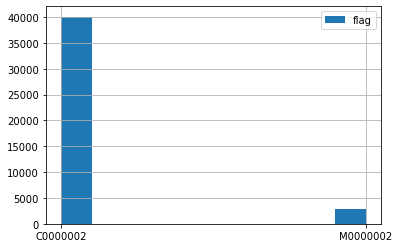

In [172]:
print('           ESTADISCIAS DEL DS_2 \n')

print(f'Flags       : {_dataset["flag"].unique()}')
print(f'Estaciones  : {len(_dataset["codigo"].unique())}')
print(f'Totales     : {_dataset["dato"].count()}')
print(f'Ceros       : {_dataset[_dataset["dato"]==0]["dato"].count()}')
print(f'Clase 0(M02): {_dataset[_dataset["flag"]=="M0000002"]["dato"].count()}')
print(f'Clase 1(C02): {_dataset[_dataset["flag"]=="C0000002"]["dato"].count()}')
print(f'Maximo      : {_dataset["dato"].max()}')
print(f'Media       : {_dataset["dato"].mean()}')
print(f'STD         : {_dataset["dato"].std()}')

#_dataset[_dataset["dato"]!=0]["dato"].hist(legend=True)
#_dataset[_dataset["dato"]>1]["dato"].hist(legend=True)
_dataset['flag'].hist(legend=True)

<AxesSubplot:>

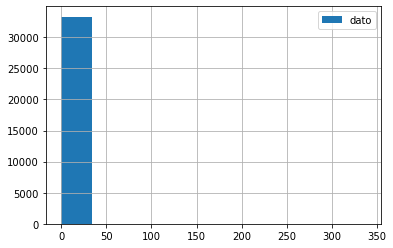

In [157]:
print('')
_dataset[_dataset["dato"]!=0]["dato"].hist(legend=True)

In [158]:
_dataset[(_dataset["dato"]>0) & (_dataset["dato"]<1)]["dato"].count()

19724

In [159]:
import wandb
from wandb.keras import WandbCallback
wandb.login()


True

In [160]:
"""
# Definimos las varibles para las iteraciones
Los parametros que van a cambiar son:
- Canales (products)
- Tiempos (Min de las imagenes)
- margen
"""
params = {'inputs'   : ['imagen'],
          'outputs'  : 'dato',  #umbral o dato/lambda
          'lambda'   : 0,
          'lr'       : 0.001,
          'batch'    : 32,        
          'dataset'  : 1,
          'epocas'   : 10,          
          'paciencia': 4,
          'canales'  : [3,2,3,2,3,2],
          'tiempos'  : [6,6,1,1,6,6],
          'margen'   : [30,30,30,20,20,20],
          'runs'     : 6
         }

In [161]:
%%time
#Solo imagenes (dato)
#resultados = trainModel(params,_dataset,path_imagenes,path_base,products,times, graficos=1)

CPU times: total: 0 ns
Wall time: 0 ns
